In [1]:
import matplotlib.pyplot as plt
from obspy.clients.fdsn import Client
import obspy

import torch
from chronos import ChronosPipeline
import numpy as np

import matplotlib.pyplot as plt

from gluonts.dataset.split import split
from einops import rearrange
from uni2ts.eval_util.data import get_gluonts_test_dataset
from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from gluonts.dataset.pandas import PandasDataset

/Users/marinedenolle/GitHub/quakeLLM/src/uni2ts/src/uni2ts/common/env.py:43: UserWarning: Failed to load .env file.
  warnings.warn("Failed to load .env file.")


In [2]:
n_samples = 100 # number of samples to generate and then take the median on
prediction_time = 15 # seconds
context_time = 20 # seconds

## Get data 
an earthquake waveform from ridgecrest

In [3]:
# some metadata

df = 5

In [4]:
# Create a client to connect to the SCEDC data center
client = Client("SCEDC")

# download a SCEDC earthquake catalog using obspy
starttime = obspy.UTCDateTime("2016-01-01")
endtime = obspy.UTCDateTime("2020-01-01")
minlatitude = 32.0
minlongitude = -125.0
maxlatitude = 42.0
maxlongitude = -114.0
minmagnitude = 6
quake_catalog = client.get_events(starttime=starttime,\
             endtime=endtime, minlatitude=minlatitude, \
                minlongitude=minlongitude, maxlatitude=maxlatitude, \
                    maxlongitude=maxlongitude, minmagnitude=minmagnitude)
print(quake_catalog)

2 Event(s) in Catalog:
2019-07-06T03:19:53.040000Z | +35.770, -117.599 | 7.1  Mw | manual
2019-07-04T17:33:49.000000Z | +35.705, -117.504 | 6.4  Mw | manual


In [5]:
# get a seismogram from CI.RPV..BHZ for the large earthquake in the first element of quake_catalog
event = quake_catalog[0]
origin = event.origins[0]
# convert the origin time to a UTCDateTime object
event_time = obspy.UTCDateTime(origin.time)
z=client.get_waveforms("CI", "RPV", "", "BH*", event_time, event_time + 60*10)
# downsample to df Hz

z.resample(df)
data = np.zeros(shape=(3, len(z[0].data)))
data[0] = z[0].data
data[1] = z[1].data
data[2] = z[2].data


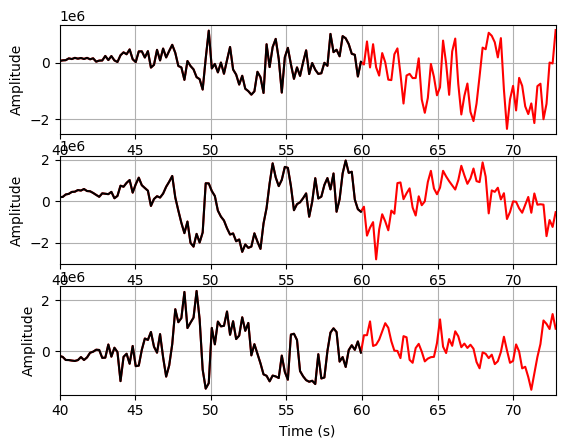

In [6]:
# now we are going to reshape the data into a format that can be used by the ChronosPipeline
# data = np.expand_dims(data, axis=0)
predict_time = prediction_time; #in sec
# n_predict will be the minimum between int(predict_time*df) and 64
n_predict = min([int(predict_time*df),64]) # index, should be less than 64 for Chronos
# n_predict = min([int(predict_time*df),64]) # index, should be less than 64 for Chronos
predict_time = n_predict/df # in sec
start_time = 40; # start in sec
nstart = int(start_time*df) # in sec
end_time = start_time+context_time; # insec
nend = int(end_time*df) # index

#create a time vector with sampling rate df
ndata_and_predict = int((predict_time+end_time-start_time)*df)
time = np.linspace(start_time, end_time+predict_time,ndata_and_predict)

fig,ax=plt.subplots(nrows=3,ncols=1)
for i in range(0,data.shape[0]):
    ax[i].plot(time,data[i,nstart:nend+n_predict],'r')
    ax[i].plot(time[:-n_predict],data[i,nstart:nend],'k')
    ax[i].set_ylabel('Amplitude')
    ax[i].set_xlabel('Time (s)')
    ax[i].set_xlim([start_time,end_time+predict_time])
    ax[i].grid();

## Chronos

Context is maximum 512 points
Prediction is maximum 64 points.

Whatch out thta MOIRAI can handle longer foreast.

In [7]:
chronos_pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)


## MOIRAI

### Settings
SIZE: model size, select the model size of Moirai to perform inference with

CTX: context length, how many time steps the model will take as input for inference

PSZ: patch size, how many time steps to perform patching with

BSZ: batch size, number of samples in each batch for inference

In [8]:
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
CTX = 368  # context length: any positive integer
PRED = n_predict  # prediction length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer

In [49]:
PRED

64

In [37]:
# Prepare model
moirai_model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
    prediction_length=PRED,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=n_samples,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)


### Moment

In [38]:
from momentfm import MOMENTPipeline

moment_model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large", 
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': prediction_time,
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': True, # Freeze the patch embedding layer
        'freeze_embedder': True, # Freeze the transformer encoder
        'freeze_head': False, # The linear forecasting head must be trained
    },
    # local_files_only=True,  # Whether or not to only look at local files (i.e., do not try to download the model).
)

## Zero-shot prediction

### Chronos

In [30]:
# Chronos just takes a densor of data
# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# forecast shape: [num_series, num_samples, prediction_length]
chronos_forecast = chronos_pipeline.predict(
    context=torch.tensor(data[:,nstart:nend], dtype=torch.float32),
    prediction_length=n_predict,
    num_samples=n_samples,
)

KeyboardInterrupt: 

In [11]:
print(chronos_forecast.shape)

torch.Size([3, 100, 64])


(3, 64)


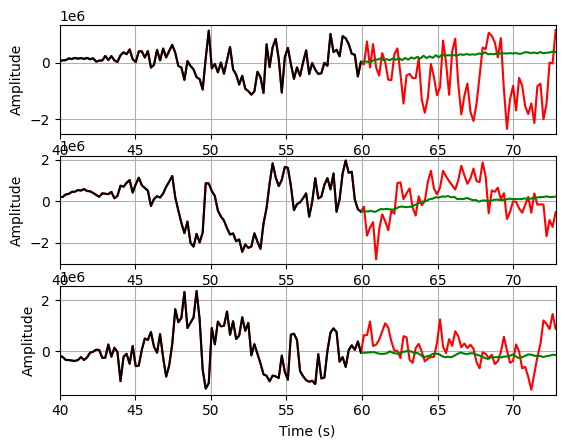

In [31]:
import matplotlib.pyplot as plt  # requires: pip install matplotlib
import numpy as np

low, median, high = np.quantile(chronos_forecast[:,:10,:].numpy(), [0.1, 0.5, 0.9], axis=1)
time_predict = np.linspace(end_time, end_time+predict_time, n_predict)
# Assuming event_counts_df is your DataFrame with a datetime index
# Get the last date from the event_counts_df index
print(median.shape)

fig,ax=plt.subplots(nrows=3,ncols=1)
for i in range(0,data.shape[0]):
    ax[i].plot(time,data[i,nstart:nend+n_predict],'r')
    ax[i].plot(time[:-n_predict],data[i,nstart:nend],'k')
    ax[i].plot(time_predict, median[i,:], 'g')
    ax[i].set_ylabel('Amplitude')
    ax[i].set_xlabel('Time (s)')
    ax[i].set_xlim([start_time,end_time+predict_time])
    ax[i].grid();

### MOIRAI


In [45]:
# Time series values. Shape: (batch, time, variate)
# add a dimension for the variate
# past_target = torch.tensor(np.expand_dims(data[:,nstart:nend], axis=0))

# past_target = rearrange(
#     torch.tensor(data[:,nstart:nend], dtype=torch.float32), "3 t -> 3 t 1" # 1 batch, t time, 1 variate
# )
past_target = rearrange(
    torch.tensor(data[0,nstart:nend], dtype=torch.float32), "t -> 1 t 1" # 1 batch, t time, 1 variate
)
# 1s if the value is observed, 0s otherwise. Shape: (batch, time, variate)
past_observed_target = torch.ones_like(past_target, dtype=torch.bool)
# 1s if the value is padding, 0s otherwise. Shape: (batch, time)
past_is_pad = torch.zeros_like(past_target, dtype=torch.bool).squeeze(-1)


In [47]:
print("Shape of past_target:", past_target.shape)
print("Shape of past_observed_target:", past_observed_target.shape)
print("Shape of past_is_pad:", past_is_pad.shape)

Shape of past_target: torch.Size([1, 100, 1])
Shape of past_observed_target: torch.Size([1, 100, 1])
Shape of past_is_pad: torch.Size([1, 100])


In [48]:
moirai_forecast = moirai_model(
    past_target=past_target,
    past_observed_target=past_observed_target,
    past_is_pad=past_is_pad)

RuntimeError: The size of tensor a (13) must match the size of tensor b (54) at non-singleton dimension 1

### MOMENT

In [ ]:
from pprint import pprint
import torch

# takes in tensor of shape [batchsize, n_channels, context_length]
x = torch.randn(16, 1, 512)
output = model(x)
pprint(output)